factor= 1.068
L=0.5,rm=0.005,Dt=1,dt=2.85156e-05
runo 62
phit 0.1
phiBD 0.0999026463842
phiLS 0.118303571429
ratio 1.0415361148
Nt 318
saving to  data/2Dcrowding_LS_mobilecrowder_phi0.1rv=1.068rm.csv
runo 20
phit 0.3
phiBD 0.299707939152
phiLS 0.354910714286
ratio 1.0415361148
Nt 954
saving to  data/2Dcrowding_LS_mobilecrowder_phi0.3rv=1.068rm.csv
runo 13
phit 0.45
phiBD 0.449876067994
phiLS 0.532738095238
ratio 1.0415361148
Nt 1432
saving to  data/2Dcrowding_LS_mobilecrowder_phi0.45rv=1.068rm.csv
runo 12
phit 0.5
phiBD 0.499827391186
phiLS 0.591889880952
ratio 1.0415361148
Nt 1591
saving to  data/2Dcrowding_LS_mobilecrowder_phi0.5rv=1.068rm.csv


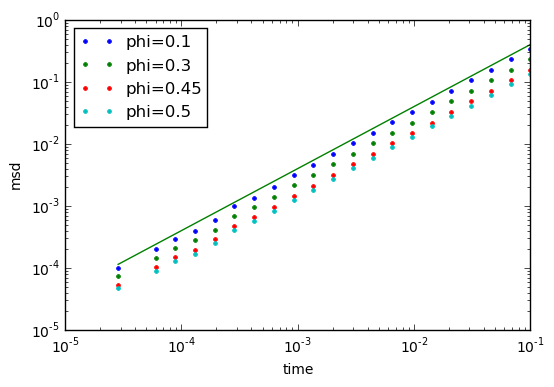

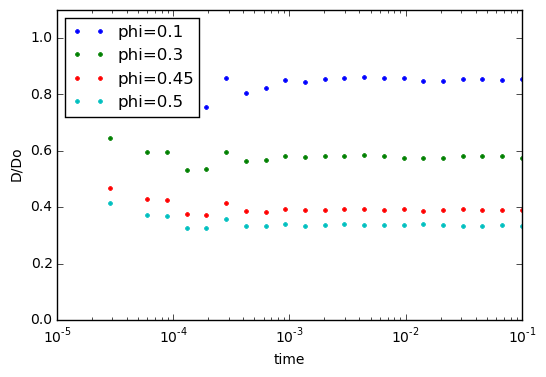

In [4]:
from ecell4 import *
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
rng = core.GSLRandomNumberGenerator()

phits = [0.1,0.3,0.45,0.5]
trajno = 20000.
rm = 0.005
L = 0.5
Dt = 1
gamma = 0.983/0.797
At = L*L
Ap = math.pi*rm*rm
H = 3*rm*2
w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rm,rng)
cs = w.row_size()
ls = w.layer_size()
Nmv = cs*ls
f = Nmv*rm*rm/At
factor = 1.068#1.079#1.088
print 'factor=',factor
rv = factor*rm
H = 3*rv*2
dt = (2*rv)**2 / (4*Dt)
ori = Real3(0.5*H,0,0)
tt = np.logspace(math.log10(2.1*dt),-1,20)
tt = np.insert(tt,0,dt)
tt = np.insert(tt,0,0.)
dur = tt[-1]
print 'L={},rm={},Dt={},dt={}'.format(L,rm,Dt,dt)
def run():
    msd = np.zeros(len(tt),float)
    Nmv = []
    for rr in range(runo):
        #print 'run',rr
        rng.seed(rr)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rv,rng)
        x,y,z = w.actual_lengths()
        with species_attributes():
            T | {'D':str(Dt),'radius':str(rv),'location':'M'}
        m=get_model()
        w.bind_to(m)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        w.add_molecules(Species('T'),Nt)
        if (rr==0):
            cs = w.row_size()
            ls = w.layer_size()
            Nmv = cs*ls
            print 'phit',str(phit)
            print 'phiBD',Nt*Ap/At
            print 'phiLS',float(Nt)/Nmv    
            print 'ratio',(Nt*Ap/At)*gamma/(float(Nt)/Nmv )
            print 'Nt',Nt
        sim = spatiocyte.SpatiocyteSimulator(w)
        pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
        #obs = FixedIntervalTrajectoryObserver(dt,pids)
        obs = TimingTrajectoryObserver(tt,pids,True,dt)
        sim.run(dur,obs)
        data=obs.data()
        for i in range(Nt):
            msd += np.array(
                [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                     for pos in data[i]]) 
        cs = w.row_size()
        ls = w.layer_size()
        Nmv = cs*ls
    #print 'no of membrane voxels',Nmv
    #print 'occupancy of tracer',float(Nt)/Nmv
    msd = msd/Nt/runo
    name = 'data/2Dcrowding_LS_mobilecrowder_phi'+str(phit)+'rv=1.068rm.csv'
    filename = open(name,'w')
    np.savetxt(filename,np.column_stack((tt,msd)),delimiter=',',fmt='%s')
    filename.close()
    print 'saving to ',name
    return msd

f1,ax1 = plt.subplots(1)
f2,ax2 = plt.subplots(1)
Deffall = []


for phit in phits:
    Nt = int(phit*At/Ap)
    unit0 = Real3(0,0,L)
    unit1 = Real3(0,L,0)
    runo = int(trajno/Nt)
    print 'runo',runo
    MSD = run()
    ax1.loglog(tt,MSD,'.',label='phi='+str(phit))
    Deff = MSD[1:]/tt[1:]/4/Dt
    ax2.semilogx(tt[1:],Deff,'.',label='phi='+str(phit))
    Deffall.append(Deff)
ax1.plot(tt,4*Dt*tt,'g-')  #theoretical line
ax1.set_xlabel("time")
ax1.set_ylabel("msd")
ax1.legend(loc='best')
ax2.set_xlabel("time")
ax2.set_ylabel("D/Do")
ax2.set_ylim(0,1.1)
ax2.legend(loc='best')
plt.show()

In [5]:
Deffs=[]
for dff in Deffall:
    Deffs.append(np.mean(dff[(tt>1e-3)[1::]]))  

[-1.29830253  0.97842423]
phi 0.5
Deff [0.85383248328639627, 0.57915272202183909, 0.39140300928375532, 0.33660027904449574]


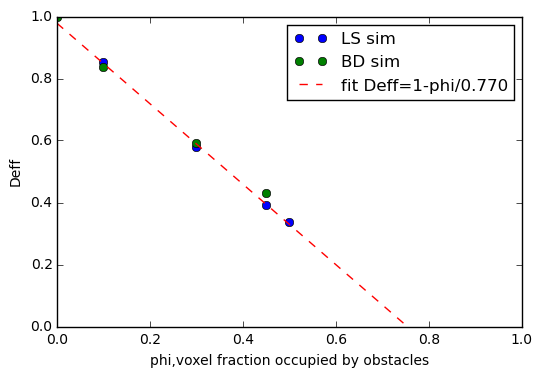

In [6]:
import scipy
from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

#phib = [0.0, 0.1, 0.2, 0.3, 0.45]
#Deffb = [1.0, 0.84850576829537339, 0.71180438024380788, 0.57800273968211158, 0.42566791085320971]

phib = [0.0, 0.1, 0.3, 0.45]
Deffb = [1.0, 0.83802969669878469, 0.59137474303309123, 0.42966984830393518]

def lin(x,m,c):
    return m*x+c 
c1,c2 = curve_fit(lin,phits,Deffs)
plt.plot(phits,Deffs,'o',label='LS sim')
plt.plot(phib,Deffb,'o',label='BD sim')
xx = np.linspace(0.0,1.,10)
print c1
plt.plot(xx,[c1[0]*i+c1[1] for i in xx],'--',label='fit Deff=1-phi/{:.3f}'.format(-1./c1[0]))
#plt.plot(xx,[(-1./0.18)*i+1. for i in xx],'--',label='Deff=1-5.55phi')
plt.xlabel('phi,voxel fraction occupied by obstacles')
plt.ylabel('Deff')
#plt.xlim(0,0.5)
plt.ylim(0.0,1)
plt.legend()
print 'phi',phit
print 'Deff',Deffs
#print 'phic=',-1./slope
#plt.savefig("figure/2DBD_diffusion_Deff_phi.png",format='png',dpi=100)
plt.show()

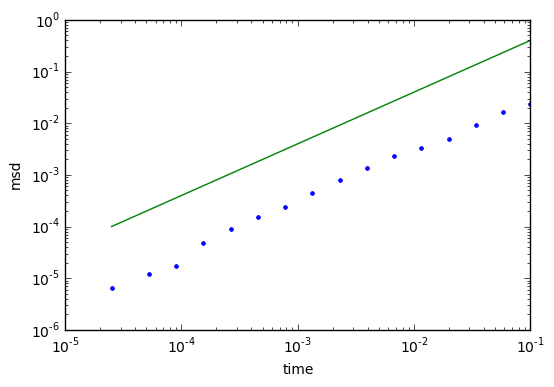

In [7]:
plt.loglog(tt,msd,'.')
plt.plot(tt,4*Dt*tt,'g-')  #theoretical line
plt.xlabel("time")
plt.ylabel("msd")
plt.show()
print 

(0, 1.1)

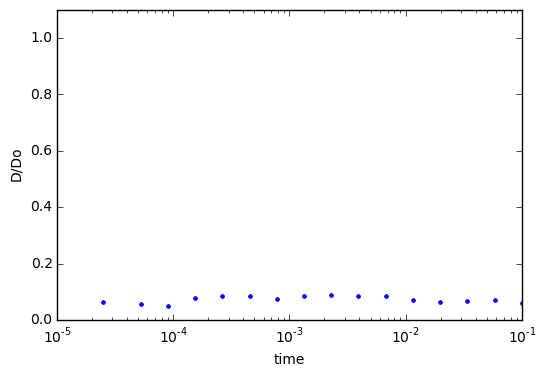

In [8]:
Deff = msd[1:]/tt[1:]/4/Dt
plt.semilogx(tt[1:],Deff,'.')
plt.xlabel("time")
plt.ylabel("D/Do")
plt.ylim(0,1.1)
#filename = open('data/2Dcrowding_LS_phi'+str(phio)+'.csv','w')
#np.savetxt(filename,np.column_stack((msd,t)),delimiter=',',fmt='%s')
#filename.close()

In [4]:
print np.mean(Deff[(t>.1)[1::]])

0.791857939863


In [20]:
dat = np.loadtxt('data/2Dcrowding_LS_phi'+str(phio)+'.csv',delimiter=',',dtype=np.str_)

In [22]:
print dat

[['0.0' '0.0']
 ['9.93548387097e-05' '2.5e-05']
 ['0.00018247311828' '5e-05']
 ..., 
 ['0.346348172043' '0.24995']
 ['0.346216236559' '0.249975']
 ['0.346320107527' '0.25']]


In [13]:
print len(p)+186+74611

186528
